# 00 - PADMe - Basic Usage

Before anything, make sure that the conda environment is installed. Using the terminal, once you are at the root directory of this project, just type:

`make create_environment`

and then:

`make requirements`

If no errors were found, we are good to go.

Welcome to the very first Jupyter Notebook using PADMe for Dynamic Mode Decomposition processing. We start by importing the necesssary packages:

In [56]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path 

from natsort import natsorted # Required for sorting filename correctly
from dotenv import find_dotenv # Required for locating project's root dir

from src import DMD # DMD class for ingesting and processing data
from src import snapshots_assembly # Function for assembling the Snapshots Matrix
from src import (
    load_notebook_params, # Function that loads predefined examples and paths
    generate_paths, # Function that creates the paths to datasets
    download_dataset, # Function that downloads the dataset from Kaggle
    unpack_kaggle_dataset, # Function that unzips the downloaded dataset
)

from src import PostProcessingDMD # Class used for postprocessing and dataviz

root_dir = os.path.dirname(find_dotenv())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's see if the `root_dir` is correctly set up. This is required for properly pointing directions to the locations where data will be stored. Make sure `root_dir` points to the root directory of this project.

In [57]:
root_dir

'/home/bombra/library/padme'

Now let's get all notebook params. This function reads from a `.yaml` file in the `notebooks/` directory that contains example file names and paths.

In [58]:
notebook_params = load_notebook_params()

Before downloading dataset, you need to create an account on Kaggle. Instructions for using the Kaggle API can be seen at sections **Installation** and **Authentication** on https://www.kaggle.com/docs/api. 


Once your `~/.kaggle/kaggle.json` file is setup, we can download the datasets used in this example.

For this notebook, we will used the `covid-19-spread-in-lombardy-italy` dataset. To download this dataset, the `example_dataset` variable can be either `sird` or `seird`. This dataset was generated when modeled the COVID-19 spread in the Lombardy region (Italy) using PDE-based compartmental models spatially discretized using the Finite Element Method. 
  
This zip file contains 991MB and contains two versions of the simulation. 
The datasets are:
- `covid-sird-lombardy-freefem` where a SIRD model was approximated and modeled using the FreeFEM++ library. More details can be seen on: `citar artigo do Alex aqui`
- `covid-seird-lombardy-libmesh` where a SEIRD model was approximated and modeled using the libMesh library. More details can be seen on: `citar artigo da Malu aqui`

In [59]:
example_dataset = "sird"

dict_paths = generate_paths(example_dataset, root_dir, notebook_params)
print(dict_paths)

download_dataset(dict_paths, example_dataset, notebook_params, FORCE_DOWNLOAD=False)
unpack_kaggle_dataset(dict_paths)

{'complete_filepath': PosixPath('/home/bombra/library/padme/data/00_raw'), 'complete_filename': PosixPath('/home/bombra/library/padme/data/00_raw/covid-19-spread-in-lombardy-italy.zip'), 'snapshots_filepath': PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem')}


If the previous cell was correctly executed, there is a zipfile in your `padme/data/00_raw/` folder and two directories, containing each one of the datasets described. They are in their raw form, that is, exactly in the form where the numerical simulations output them.

This is one of the most annoying parts of DMD architectures and **PADMe** aims to automatize this procedure. If you explore the two generated folders, you will see that the `susceptible` snapshots on the `covid-sird-lombardy-freefem` dataset are of the form:
- `covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/4susceptible.vtk`
- `covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/8susceptible.vtk`
- `covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/12susceptible.vtk`

while the `susceptible` snapshots on the `covid-seird-lombardy-libmesh` dataset are of the form:
- `covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step0/out_1_000_00000.h5`
- `covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step0/out_1_000_00001.h5`
- `covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step0/out_1_000_00002.h5`
being `s` the dataset inside the `.h5` files containing the susceptibles data.

This difference in structure delays the application of DMD to multiple datasets and usually requires attention and time of the engineer. Using **PADMe**, we need to create a list of strings (or Path) containing the snapshots absolute filename. The following cell does that for the first case.

In [60]:
os_walk_files = next(os.walk(dict_paths["snapshots_filepath"]))
files = natsorted(os_walk_files[2])

filenames = [
    dict_paths["snapshots_filepath"] / Path(f"{str(i)}infected.vtk")
    for i, _ in zip(range(4, 480, 4), files)
]

Let's check if the five first and last filenames are correct: 

In [61]:
filenames[:5]

[PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/4infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/8infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/12infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/16infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/20infected.vtk')]

In [62]:
filenames[-5:]

[PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/460infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/464infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/468infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/472infected.vtk'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-sird-lombardy-freefem/covid-sird-lombardy-freefem/476infected.vtk')]

Now that our list of filenames is complete, we can create the `snapshot_ingestion_parameters` dictionary. Given that the `sird` simulation consists of ASCII `.vtk` files, we can take a look at one of them to see the starting and ending lines where nodal values were stored. In this case, the dictionary is the following:

In [63]:
snapshot_ingestion_parameters = {
    "filenames": filenames,
    "starting_line": 125939,
    "ending_line": 210239,
}

Now let's load our dataset using `snapshots_assembly`

In [64]:
dataset = snapshots_assembly(
    "vtk_freefem", snapshot_ingestion_parameters=snapshot_ingestion_parameters
)
dataset.shape

2023-04-16 22:51:52,478 - src.preprocessing.build_snapshots - INFO - Starting choice of file type:
2023-04-16 22:51:52,479 - src.preprocessing.build_snapshots - INFO - FreeFem++ vtk file selected.


(84300, 119)

Now our snapshots matrix contain all snapshots and dimensions of `(84300, 119)`. It is now ready to be ingested on the DMD class. Let's see how it works for libMesh/EdgeCFD `.h5` files. We need to regenerate the `dict_paths` that points to the folders containing the data. We don't need to redownload any datasets, but the functions will check that for us:

In [65]:
example_dataset = "seird"

dict_paths = generate_paths(example_dataset, root_dir, notebook_params)
dict_paths

download_dataset(dict_paths, example_dataset, notebook_params, FORCE_DOWNLOAD=False)
unpack_kaggle_dataset(dict_paths)

Now proceeding with our list of filenames:

In [66]:
os_walk_files = next(os.walk(dict_paths["snapshots_filepath"]))
folders = natsorted(os_walk_files[1])

filenames = [
    dict_paths["snapshots_filepath"]
    / Path(snapshot_folder)
    / Path(f"out_1_000_{str(i).zfill(5)}.h5")
    for i, snapshot_folder in enumerate(folders)
]

Checking the beginning and the end of the list:

In [67]:
filenames[:5]

[PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step0/out_1_000_00000.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step1/out_1_000_00001.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step2/out_1_000_00002.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step3/out_1_000_00003.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step4/out_1_000_00004.h5')]

In [68]:
filenames[-5:]

[PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step477/out_1_000_00477.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step478/out_1_000_00478.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step479/out_1_000_00479.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step480/out_1_000_00480.h5'),
 PosixPath('/home/bombra/library/padme/data/00_raw/covid-seird-lombardy-libmesh/covid-seird-lombardy-libmesh/step481/out_1_000_00481.h5')]

Now we fill the `snapshot_ingestion_dictionary` and let's assemble our snapshots matrix:

In [109]:
snapshot_ingestion_parameters = {
    "filenames": filenames,
    "dataset": "s",
}

In [110]:
dataset = snapshots_assembly(
    "h5_libmesh", snapshot_ingestion_parameters=snapshot_ingestion_parameters
)
dataset.shape

2023-04-16 22:59:05,120 - src.preprocessing.build_snapshots - INFO - Starting choice of file type:
2023-04-16 22:59:05,121 - src.preprocessing.build_snapshots - INFO - libMesh/EdgeCFD HDF5 file selected.


(13158, 482)

And now we have our snapshots matrix containing dimensions `(13158, 482)`. Let's fill the `dmd_parameters` dictionary and process this data.

In [141]:
dmd_parameters = {
    "factorization_algorithm": "randomized_svd",
    "basis_vectors": 25,
    "randomized_svd_parameters": {
        "power_iterations": 1,
        "oversampling": 20,
    },
    "starting_step": 25,  # Can be 0 for susceptibles, but should be >0 for zero initialized fields.
    "dt_simulation": 0.05,
}

Now we instantiate our `DMD` class:

In [142]:
dmd = DMD(dataset, dmd_parameters)

The `.factorization()` method is responsible for calling the factorization method added in the `dmd_parameters` dictionary. In this case, it is the `randomized_svd` algorithm:

In [143]:
dmd.factorization()

All the outputs obtained on objects instantiated on the `DMD` class contain an attribute called `.dmd_approximation`. This attribute is a dictionary containing all possible outputs from the DMD processing. Let's see our singular values from the `.factorization()` method.  

In [144]:
dmd.dmd_approximation["s"]

array([1.96658875e+06, 1.37641076e+05, 2.38207835e+04, 5.60003842e+03,
       1.71063331e+03, 7.09952010e+02, 3.47684699e+02, 1.99597805e+02,
       1.17514463e+02, 3.97103015e+01, 2.89631227e+01, 1.46517181e+01,
       8.22398630e+00, 4.75271684e+00, 1.00521449e+00, 1.34209151e-01,
       6.09225334e-02, 4.53188022e-02, 2.58325774e-02, 1.59142773e-02,
       1.33906276e-02, 9.87977116e-03, 5.52560873e-03, 3.42097609e-03,
       1.99925589e-03])

Now let's proceed to compute our DMD approximation. We invoke the `.dmd_core()` method from the `dmd` object.

In [145]:
dmd.dmd_core()

Now let's take a look at our outputs:

In [146]:
dmd.dmd_approximation.keys()

dict_keys(['snapshots_matrix', 'u', 's', 'vt', 'eigenvals_original', 'eigenvals_processed', 't', 'dmd_matrix'])

The `.dmd_approximation` attribute contains the following keys:
- `'snapshots_matrix'` : the sliced snapshots_matrix `[starting_step : ending_step]`
- `'u'` : the $\mathbf{U}$ matrix from SVD
- `'s'` : the $\mathbf{\Sigma}$ matrix from SVD
- `'vt'` : the $\mathbf{V}^T$ matrix from SVD
- `'eigenvals_original'` : Eigenvalues from $\tilde{\mathbf{A}}$ matrix
- `'eigenvals_processed'` : Eigenvalues from $\tilde{\mathbf{A}}$ matrix after $log(\Lambda)/\Delta t$
- `'t'` : array containing time steps used for approximation
- `'dmd_matrix'` : the DMD approximation for all times existent in key `'t'`

Now we can postprocess our data and visualize the results. Let's instantiate the `PostProcessingDMD` class.

In [147]:
dmd_visualizer = PostProcessingDMD(dmd.dmd_approximation)

Let's plot the singular values using the `.plot_singular_values()` method. All visualization methods are implemented for `matplotlib`, `seaborn` and `plotly` libraries.

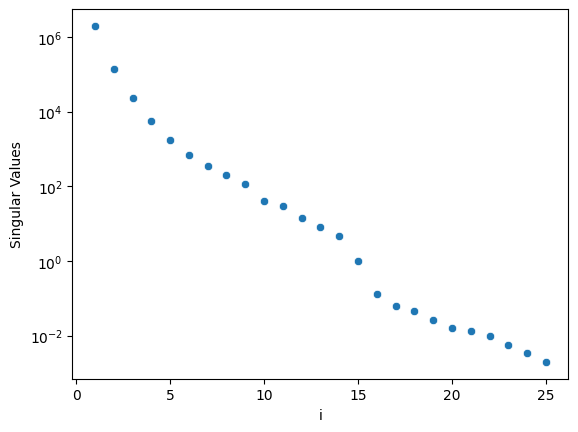

In [148]:
dmd_visualizer.plot_singular_values("seaborn")

This does make sense. Now let's take a look at the eigenvalues of $\mathbf{\tilde{A}}$ and see if our modes are stable. We can plot the eigenvalues using the `.plot_eigenvalues()` method`.

In [149]:
dmd_visualizer.plot_eigenvalues("plotly")

Finally, let's see the quality of our approximation. We can compute the $\mathcal{L}_2$ norm in time between approximation and original data with the `.compute_temporal_l2_norm()` method.

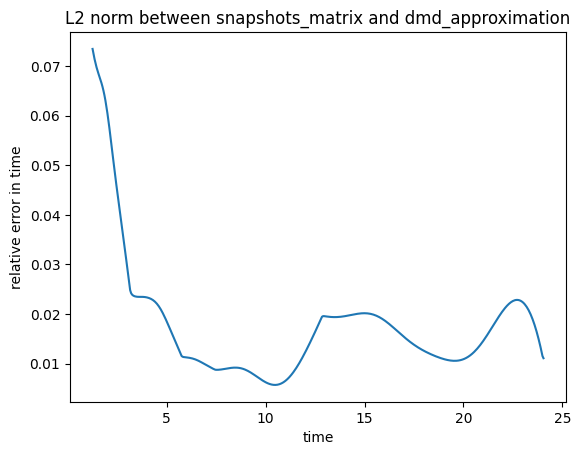

In [150]:
dmd_visualizer.compute_temporal_l2_norm("seaborn")